#?title=Rectifier ripple voltage and current

#?categories=Electronic design

#?tags=rectifier;ripple voltage;ripple current;

An accurate bridge rectifier model for capacitor selection.

#?remove_output
$$
\require{newcommand}
\newcommand{\abs}[1]{\left|#1\right|}
\newcommand{\norm}[1]{\left\Vert#1\right\Vert}
\newcommand{\block}[1]{\left[#1\right]}
\newcommand{\seq}[1]{\left<#1\right>}
\newcommand{\par}[1]{\left(#1\right)}
\newcommand{\re}[1]{\mathrm{re}\left(#1\right)}
\newcommand{\im}[1]{\mathrm{im}\left(#1\right)}
\newcommand{\m}[1]{\mathrm{#1}}
$$

## An accurate bridge rectifier model for capacitor selection

Let's build a simple but accurate model for a bridge rectifier with capacitor, and that will allow us to
select the best capacitor for the job.

You can download this notebook and other files from [My Github repository](https://github.com/luchp/notebooks)

Knowing the maximum load current, there are two properties that are important to calculate, the required
capacitance and ripple current.

### Spice simulation

Let's start with simulating a mains (230V) single phase bridge rectifier with Spice: see next two picture
for the schematic and simulation result.
<p> <img src="single_phase_bridge_rectifier_schematic.jpg"
     alt="Bridge rectifier schematic" height="50%">
</p>

<p> <img src="single_phase_bridge_rectifier_2.jpg"
    alt="Bridge rectifier simulation result" height="50%">
</p>

As you can see, the output voltage curve has three section.
- From the start at t=0, at the crest of the sine to time $t=\tau_1$.
  During this section the output voltage follows the sine, until the sine voltage drop to fast.
  At $\tau_2$ the derivative of the sine is equal to the derivative of the capacitor discharge line.
- From $t=\tau_1$ to $t=\tau_2$ where the output voltage is straight line with slope $-I_{load} / C$ and
  the capacitor provides all the current.
- From $\tau_2$ to the crest of the next sine, at $t=T$, the end of the period. During this section
  the output voltage follows the sine and the capacitor is charging.

### More phases

The peak of this second sine is at $T/2$ for single phase bridge rectifier depicted above,
but this varies if we have more phases or if we use a single ended rectifier
(just one diode per phase).

In general the second sine peak is at $T/n$ where n is the number af phases of a single ended rectifier
and twice the number of phases for a bridge rectifier.

### Maths

We know the amplitude of the sine $U_0$ and the minimum acceptable voltage at the end of
the second section $U_1$. The difference between the two is the ripple voltage $U_{ripple} = U_0 - U_1$.

If the sines overlap (which is the case for $n>2$ then $U_1$ can not be zero, but has a minimum that is right in the middle of the two sines, or $U_1 > U_0 \m{sin}\par{\frac{\pi}{n}} \m{\ if\ } n > 2$

And we can write down  equations for $\tau_1$ and $\tau_2$:
$$
\begin{align}
\tau_2 &= \frac{T}{n} - \frac{T}{2 \pi} \m{acos} \par{ \frac{U_1}{U_0} } \\
U_1 &= U_0 \, \m{cos}\par{\frac{2 \pi}{T}  \tau_1} - \par{\tau_2 - \tau_1} \frac{I_{load}}{C} \\
- U_0 \frac{2 \pi}{T}  \m{sin}\par{\frac{2 \pi}{T} \tau_1} &= - \frac{I_{load}}{C}
\end{align}
$$
* The first equation calculates the end of the second section $\tau_2$ from the known voltages $U_1$ and $U_2$.
* The second equation is the straight line from $\tau_1$ to $\tau_2$ with slope $-\frac{I_{load}}{C}$
* The third equation states that at $\tau_1$ the derivative of the sine is the same als the straight line with slope $-\frac{I_{load}}{C}$

The last two equation for $\tau_1$ do not have a symbolic solution, so we have to solve them numerically, which we'll do next.

In [1]:
import numpy as np
import scipy.optimize as sopt
import matplotlib.pyplot as plt

from numlib import numplot

def rectifier_paramters(U0: float, U1: float, T: float, nphase: int) -> tuple[float, float, float, float, float]:
    """
    Calculate discharge curve parameters for a rectifier
    
    Parameters:
    U0: Rectified sine amplitude
    U1: Minimum output voltage
    T: Period time of sine
    nphase: Number of phases if it is a halve wave rectifier.
            Number of phases times two if it is a full wave rectifier.
            
    Returns
    tau1: start of capacitor discharge line
    Ux: voltage at tau1
    tau2: end of capacitor discharge line
    U1: voltage at tau2
    C: Minimum required capacitance if load current is 1[A]
       For other load currents multiply C with the required load current.
    """
    # Calculate the minimum output voltage without any capacitor
    U1min = U0*np.cos(np.pi/nphase) if nphase > 2 else 0.
    if U1 < U1min:
        return 0.5*T/nphase, U1min, 0.5*T/nphase, U1min, 0
    
    # Solve for tau1
    w = 2*np.pi/T
    tau2 = T/nphase - np.arccos(U1/U0)/w
    
    def eq(tau1):
        return U1 - U0*np.cos(w*tau1) + U0*(tau2 - tau1)*w*np.sin(w*tau1)
    
    tau1 = sopt.brentq(eq, 0, min(T/4, tau2))
    
    # calculate C assuming a load current of 1[A]
    C = 1/(U0*w*np.sin(w*tau1))
    return tau1, U0*np.cos(w*tau1), tau2, U1, C



### Plotting

Now that we have a function to calculate the discharge parameters, we can make some nice plots.

In a next blog we will extend the function to include ripple current and apply it to some real world problems. 

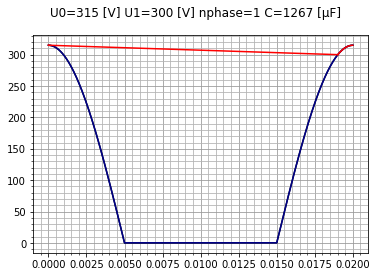

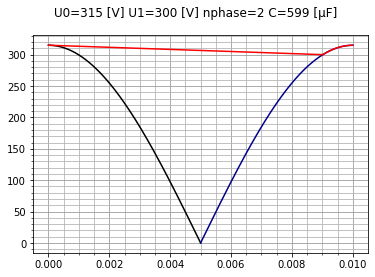

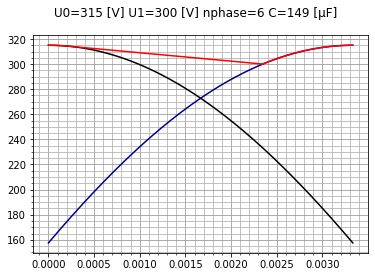

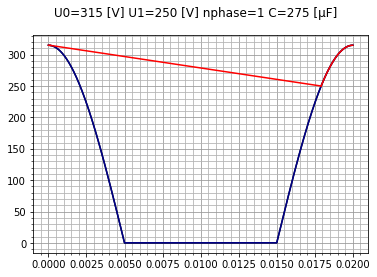

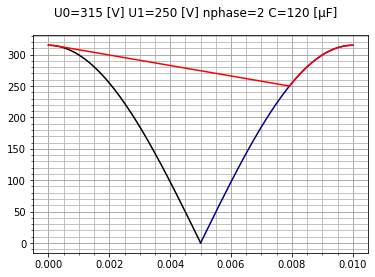

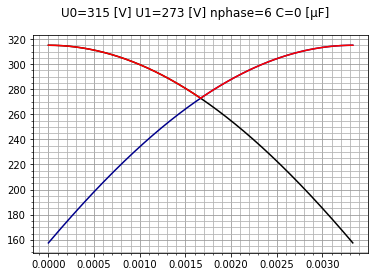

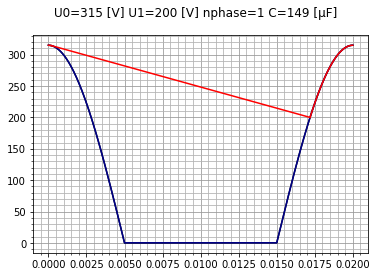

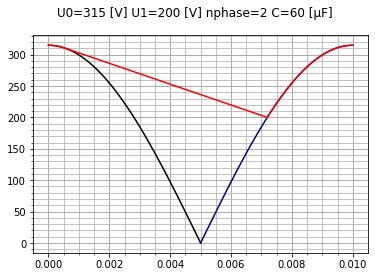

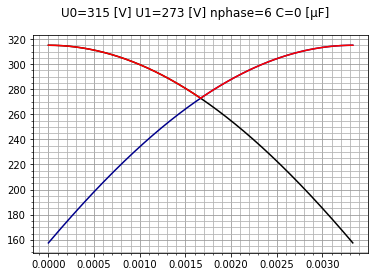

In [3]:
def plot_discharge_lines(U0: float, U1: float, T: float, nphase: int):
    if U0 <= 0. or U1 > U0 or T <= 0. or nphase <= 0:
        raise ValueError("Parameters out of range")
        
    tau1, Ux, tau2, U1, C = rectifier_paramters(U0, U1, T, nphase)
    w = 2*np.pi/T
    fig, ax = plt.subplots()
    npoints = 10000
    
    dt = (T/nphase)/npoints
    tt = np.arange(npoints)*dt
    
    # plot the two sines but not the parts that are < 0
    sine1, sine2 = U0*np.cos(w*tt), U0*np.cos(w*(tt - T/nphase))
    ax.plot(tt[sine1>0], sine1[sine1>0], color="black", label="First sine")
    ax.plot(tt[sine2>0], sine2[sine2>0], color="darkblue", label="Second sine")
    
    # plot the discharge lines
    i1, i2 = round(tau1/dt), round(tau2/dt)
    ax.plot(tt[:i1], sine1[:i1], color="red")
    ax.plot(tt[i1:i2], Ux + (U1-Ux)*(tt[i1:i2] - tau1)/(tau2 - tau1), color="red")
    ax.plot(tt[i2:], sine2[i2:], color="red")
    numplot.gridsetup(ax)
    fig.suptitle(f"{U0=:.0f} [V] {U1=:.0f} [V] {nphase=} C={1e6*C:.0f} [μF]")
    return fig, ax
    

for U1 in (300, 250, 200):
    for nphase in (1, 2, 6):
        plot_discharge_lines(315, 300, 1/50, nphase)